### Mounting drive

### imports

In [192]:
import os
import pandas as pd
from tqdm import tqdm
import re
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import seaborn as sns

### Set Paths

In [2]:
BASE_PATH = "."    # Change this to run in colab

RAW_DATA_FOLDER = "data"
MODIFIED_DATA_FOLDER = "generated"
TEMPORARY_DATA_FOLDER = "temp"
IMAGES_FOLDER = "images"

VIDEOS_METADATA_FILE = 'yt_metadata_en.jsonl.gz'
TECH_CATEGORY_FILE = 'science_and_technology_videos.csv'
SMARTPHONES_DATA = "Phone_to_Smartphone.csv"
VIDEOS_BRANDS_DATA = "videos_with_brands_metadeta.csv"

### Constants

In [3]:
VIDEOS_METADATA_COLUMNS = ["categories", "channel_id", 
                           "crawl_date", "description", 
                           "dislike_count", "display_id", 
                           "duration", "like_count", "tags", 
                           "title", "upload_date", "view_count"]

CATEGORY = 'Science & Technology'
CHUNK_SIZE = 500_000

MONTHS_NAMES = ["January", "February", "March", 
                "April", "May", "June", "July", 
                "August", "September", "October", 
                "November", "December"]

BRANDS_TO_ANALYZE = ["Samsung", "Apple" ,"LG", "Huawei", "Xiaomi", "Oppo", ]

## Utility Functions

In [193]:
def capture_year(string):
    year = re.search('([0-9]{4})',string)
    if year:
        return int(year.group(0))
    else:
        return -1

In [194]:
def get_brand_models(brand_name, df):
    return df[df.Brand == brand_name].Name.unique()

In [195]:
def find_brand(row, brand_models):
    brands_mentioned = []
    for brand in brand_models.keys():
        for model in brand_models[brand]:
            model = model.lower()
            if (model in row.title.lower()
                or (model in row.description.lower())
                or model in row.tags.lower()):
                brands_mentioned.append(brand)
                break
    if len(brands_mentioned) == 0:
        return None
    return brands_mentioned

In [196]:
def calc_release(row, months):
    year = row.released_year
    release = re.sub(r"\s*Released\s*", "", row.released_at, flags=re.IGNORECASE)
    
    full_date = re.search(r"[0-9]{4}, [a-z]+\s[0-9]{2}", release, flags=re.IGNORECASE)
    quarters_date = re.search(r"[0-9]{4}, [A-Z][1-4]", release, flags=re.IGNORECASE)
    months_date = re.search(r"[0-9]{4}, [a-z]+", release, flags=re.IGNORECASE)
    years_date = re.search(r"[0-9]{4}", release)
    
    if full_date:
        return pd.to_datetime(full_date.group(0))
    elif quarters_date:
        q = int(quarters_date.group(0)[-1])
        m = months[(q-1)*3 + 1]
        return pd.to_datetime("{}/{}".format(m, year))
    elif months_date:
        return pd.to_datetime(months_date.group(0))
    elif years_date:
        return pd.to_datetime(years_date.group(0))
    else:
        return None

In [244]:
def get_plot(brands, column_name, aggregation, brand_videos, figsize=(20, 10), title="", x_label="", y_label="", interval="QS", whole_data=None) : 
    fig = plt.figure(figsize=figsize, dpi=80)
    
    for idx, brand in enumerate(brands):
        
        if brand != "Oppo":
            df = brand_videos[brand]

            #computing the mean per mont
            mean_views = df[column_name].resample(interval).agg(aggregation)
            mean_views[mean_views.isna()] = 0      # months where no video appear should have mean zero

            #plotting
            plt.plot(mean_views, label=brand, lw=3)
            #sns.lineplot(data=df[column_name], estimator=aggregation, label=brand, lw=3)#, x="upload_date", y=mean_views)

    #plotting the overall statistic
    if whole_data is not None:
        global_statistic = whole_data[column_name].resample(interval).agg(aggregation)
        global_statistic[global_statistic.isna()] = 0
        plt.plot(global_statistic, label="all data", lw=2, ls="--", color="grey") 
        #sns.lineplot(data=global_statisic, estimator=aggregation, label="all data", lw=2, ls="--", color="grey")


    #plt.yscale('log')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

In [245]:
def get_plot_cummulative(brands, column_name, aggregation, brand_videos, figsize=(20, 10), title="", x_label="", y_label="", interval="QS", whole_data=None) : 
    fig = plt.figure(figsize=figsize, dpi=80)
    
    for idx, brand in enumerate(brands):
        
        if brand != "Oppo":
            df = brand_videos[brand]

            #computing the mean per mont
            mean_views = df[column_name].resample(interval).agg(aggregation)
            mean_views[mean_views.isna()] = 0     # months where no video appear should have mean zero
            mean_views = mean_views.cumsum()
            #plotting
            plt.plot(mean_views, label=brand, lw=3)
            #sns.lineplot(data=df[column_name], estimator=aggregation, label=brand, lw=3)#, x="upload_date", y=mean_views)

    #plotting the overall statistic
    if whole_data is not None:
        global_statistic = whole_data[column_name].resample(interval).agg(aggregation)
        global_statistic[global_statistic.isna()] = 0
        global_statistic = global_statistic.cumsum()
        plt.plot(global_statistic, label="all data", lw=2, ls="--", color="grey") 
        #sns.lineplot(data=global_statisic, estimator=aggregation, label="all data", lw=2, ls="--", color="grey")


    #plt.yscale('log')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

## Videos Filtering

### Read Raw Data

In [4]:
%%time
raw_data_reader = pd.read_json(os.path.join(BASE_PATH, RAW_DATA_FOLDER, VIDEOS_METADATA_FILE), 
                           compression="infer", chunksize=CHUNK_SIZE, lines=True)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


### Extract Tech and Science Videos

In [5]:
%%time
for data_chunk in tqdm(raw_data_reader):
    tech_videos = data_chunk[data_chunk.categories == CATEGORY]
    tech_videos.to_csv(os.path.join(BASE_PATH, MODIFIED_DATA_FOLDER, TECH_CATEGORY_FILE), 
                      mode='a', header=False, columns = VIDEOS_METADATA_COLUMNS)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


### Load Tech & Science Videos Data

In [13]:
processed_data_reader = pd.read_csv(os.path.join(BASE_PATH, MODIFIED_DATA_FOLDER, TECH_CATEGORY_FILE), 
                                    names=VIDEOS_METADATA_COLUMNS)

In [14]:
processed_data_reader.columns

Index(['categories', 'channel_id', 'crawl_date', 'description',
       'dislike_count', 'display_id', 'duration', 'like_count', 'tags',
       'title', 'upload_date', 'view_count'],
      dtype='object')

In [15]:
processed_data_reader.head()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
3968,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:31.549534,Climate change threatens to make dry regions e...,503.0,XPSYzLZ7xKU,200,15328.0,"seeker,science,curiosity,education,explain,lea...",Transforming Air Into Pure Drinking Water Is F...,2019-10-03 00:00:00,357909.0
3969,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:32.224556,We now have a new understanding of the undergr...,84.0,WWD_1Nq6iwQ,308,6498.0,"seeker,science,curiosity,education,explain,lea...",This Underground Economy Exists in a Secret Fu...,2019-10-02 00:00:00,151492.0
3970,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:32.905550,Glaucoma is one of the leading causes of blind...,36.0,0U1rkFraBQo,399,2723.0,"SICK,science,health,health news,health tech,te...",How Does Glaucoma Cause Vision Loss?,2019-10-01 00:00:00,63057.0
3971,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:33.614600,NASA and Arizona State University plan to send...,111.0,NMknT8vKOL8,292,5274.0,"NASA,Arizona State University,asteroid,asteroi...",This Metal Asteroid Could Reveal Secrets About...,2019-09-30 00:00:00,229530.0
3972,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:34.300370,An international team of scientists and engine...,156.0,s0P9hj1R_Zw,486,10025.0,"focal point,documentary,interview,short doc,sc...","The International Hunt for Dark Energy Is On, ...",2019-09-29 00:00:00,322653.0


### Check and Clean Data

In [16]:
(processed_data_reader.dislike_count.isna() == processed_data_reader.like_count.isna()).sum() == len(processed_data_reader)

True

In [17]:
processed_data_reader.tags.replace(np.nan, "", inplace=True)
processed_data_reader.description.replace(np.nan, "", inplace=True)

## Phones & Tablets Filtering

### Load data 

In [18]:
phone_models_df = pd.read_csv(os.path.join(BASE_PATH, RAW_DATA_FOLDER, SMARTPHONES_DATA))

### Processing the release Date

In [19]:
phone_models_df["released_year"] = phone_models_df.released_at.apply(lambda x : capture_year(str(x)))

In [20]:
# Remove unreleased/Cancelled phones
phone_models_df.drop(phone_models_df[phone_models_df["released_year"] == -1].index, axis=0, inplace=True)

In [23]:
phone_models_df["release"] = phone_models_df.apply(lambda x : calc_release(x, MONTHS_NAMES), axis=1)

In [24]:
phone_models_df[~phone_models_df.release.isna()].release.count()

10241

In [25]:
phone_models_df.count()

id                      10241
Brand                   10241
Name                    10241
Status                  10241
coverImage              10241
released_at             10241
body                    10030
os                      10241
Chipset                  5385
Colors                   9684
camera_pixels           10241
battery_size            10241
Type                    10239
Dual                      626
Triple                    363
Charging                 1440
Size                     9110
Resolution              10202
Other_specifications    10241
released_year           10241
release                 10241
dtype: int64

In [27]:
phone_models_df = phone_models_df.set_index("release")

In [28]:
phone_models_df.head(5)

,id,Brand,Name,Status,coverImage,released_at,body,os,Chipset,Colors,camera_pixels,battery_size,Type,Dual,Triple,Charging,Size,Resolution,Other_specifications,released_year
release,,,,,,,,,,,,,,,,,,,,
1999-01-01,1,Nokia,Nokia 3210,Discontinued,https://fdn2.gsmarena.com/vv/bigpic/no3210b.gif,Released 1999,"151g, 22.5mm thickness",Feature phone,NaN,User exchangeable front and back covers,NO,&nbsp;,Removable Li-Ion battery,NaN,NaN,NaN,NaN,5 lines,"{""storage"":""No card slot"",""video_pixels"":""No v...",1999
1998-01-01,2,Nokia,Nokia 5110,Discontinued,https://fdn2.gsmarena.com/vv/bigpic/no5110b.gif,Released 1998,"170g, 31mm thickness",Feature phone,NaN,"Xpress-On covers, 4 basic, 7 metallic",NO,600 mAh,Removable Li-Po 600 mAh battery,NaN,NaN,NaN,NaN,5 lines,"{""storage"":""No card slot"",""video_pixels"":""No v...",1998
1998-01-01,3,Nokia,Nokia 6110,Discontinued,https://fdn2.gsmarena.com/vv/bigpic/no6110b.gif,Released 1998,"137g, 28mm thickness",Feature phone,NaN,2,NO,600 mAh,Removable Li-Po 600 mAh battery,NaN,NaN,NaN,NaN,5 lines,"{""storage"":""No card slot"",""video_pixels"":""No v...",1998
1998-01-01,4,Nokia,Nokia 6130,Discontinued,https://fdn2.gsmarena.com/vv/bigpic/no6130b.gif,Released 1998,"152g, 25mm thickness",Feature phone,NaN,2,NO,600 mAh,Removable Li-Po 600 mAh battery (BPS-1),NaN,NaN,NaN,NaN,5 lines,"{""storage"":""No card slot"",""video_pixels"":""No v...",1998
1998-01-01,5,Nokia,Nokia 6150,Discontinued,https://fdn2.gsmarena.com/vv/bigpic/no6150b.gif,Released 1998,"141g, 28mm thickness",Feature phone,NaN,2,NO,600 mAh,Removable Li-Po 600 mAh battery (BPS-1),NaN,NaN,NaN,NaN,5 lines,"{""storage"":""No card slot"",""video_pixels"":""No v...",1998


### Filter to Match timeframe with Videos

In [29]:
# Filter to match the range of youtube data
filtered_phones = phone_models_df[(phone_models_df["released_year"] > 2004) & (phone_models_df["released_year"] < 2020)]

In [30]:
filtered_phones.columns

Index(['id', 'Brand', 'Name', 'Status', 'coverImage', 'released_at', 'body',
       'os', 'Chipset', 'Colors', 'camera_pixels', 'battery_size', 'Type',
       'Dual', 'Triple', 'Charging', 'Size', 'Resolution',
       'Other_specifications', 'released_year'],
      dtype='object')

In [31]:
filtered_phones.head()

,id,Brand,Name,Status,coverImage,released_at,body,os,Chipset,Colors,camera_pixels,battery_size,Type,Dual,Triple,Charging,Size,Resolution,Other_specifications,released_year
release,,,,,,,,,,,,,,,,,,,,
2006-05-01,803,Samsung,Samsung E500,Discontinued,https://fdn2.gsmarena.com/vv/bigpic/sse500.gif,"Released 2006, May","77g, 21.9mm thickness",Feature phone,NaN,NaN,1.3 MP,800 mAh,Removable Li-Ion 800 mAh battery,NaN,NaN,NaN,"1.76 inches, 9.7 cm2 (~25.8% screen-to-body ra...",176 x 220 pixels (~160 ppi density),"{""storage"":""60MB storage, no card slot"",""video...",2006
2005-02-01,969,Panasonic,Panasonic X800,Discontinued,https://fdn2.gsmarena.com/vv/bigpic/pax800.gif,"Released 2005, Q1","99g, 17mm thickness","Symbian OS 7.0s, Series 60 v2.0 UI",NaN,NaN,0.3 MP,720 mAh,Removable Li-Ion 720 mAh battery,NaN,NaN,NaN,"2.2 inches, 36 x 43 mm, 15.4 cm2 (~32.1% scree...",176 x 208 pixels (~124 ppi density),"{""storage"":""8MB storage, miniSD slot"",""video_p...",2005
2005-02-01,972,Nokia,Nokia 6822,Discontinued,https://fdn2.gsmarena.com/vv/bigpic/no6822.gif,"Released 2005, Q1","100g, 21mm thickness",Feature phone,NaN,NaN,0.3 MP,850 mAh,Removable Li-Ion 850 mAh battery (BL-5C),NaN,NaN,NaN,"1.5 inches, 7.3 cm2 (~14.9% screen-to-body ratio)","128 x 128 pixels, 8 lines, 1:1 ratio (~121 ppi...","{""storage"":""3.5MB storage, no card slot"",""vide...",2005
2005-02-01,973,LG,LG F2300,Discontinued,https://fdn2.gsmarena.com/vv/bigpic/lgf2300.gif,"Released 2005, Q1","91g, 24mm thickness",Feature phone,NaN,NaN,0.3 MP,1000 mAh,Removable Li-Ion 1000 mAh battery,NaN,NaN,NaN,NaN,"128 x 160 pixels, 7 lines","{""storage"":""3.5MB storage, no card slot"",""vide...",2005
2005-02-01,974,LG,LG G1610,Discontinued,https://fdn2.gsmarena.com/vv/bigpic/lgg1610.gif,"Released 2005, Q1","83g, 17mm thickness",Feature phone,NaN,NaN,NO,950 mAh,Removable Li-Ion 950 mAh battery,NaN,NaN,NaN,"1.5 inches, 7.3 cm2 (~15.9% screen-to-body ratio)","128 x 128 pixels, 1:1 ratio (~121 ppi density)","{""storage"":""1.1MB storage, no card slot"",""vide...",2005


### Show Brands with most Phones

Text(0.5, 0, 'No. of Models')

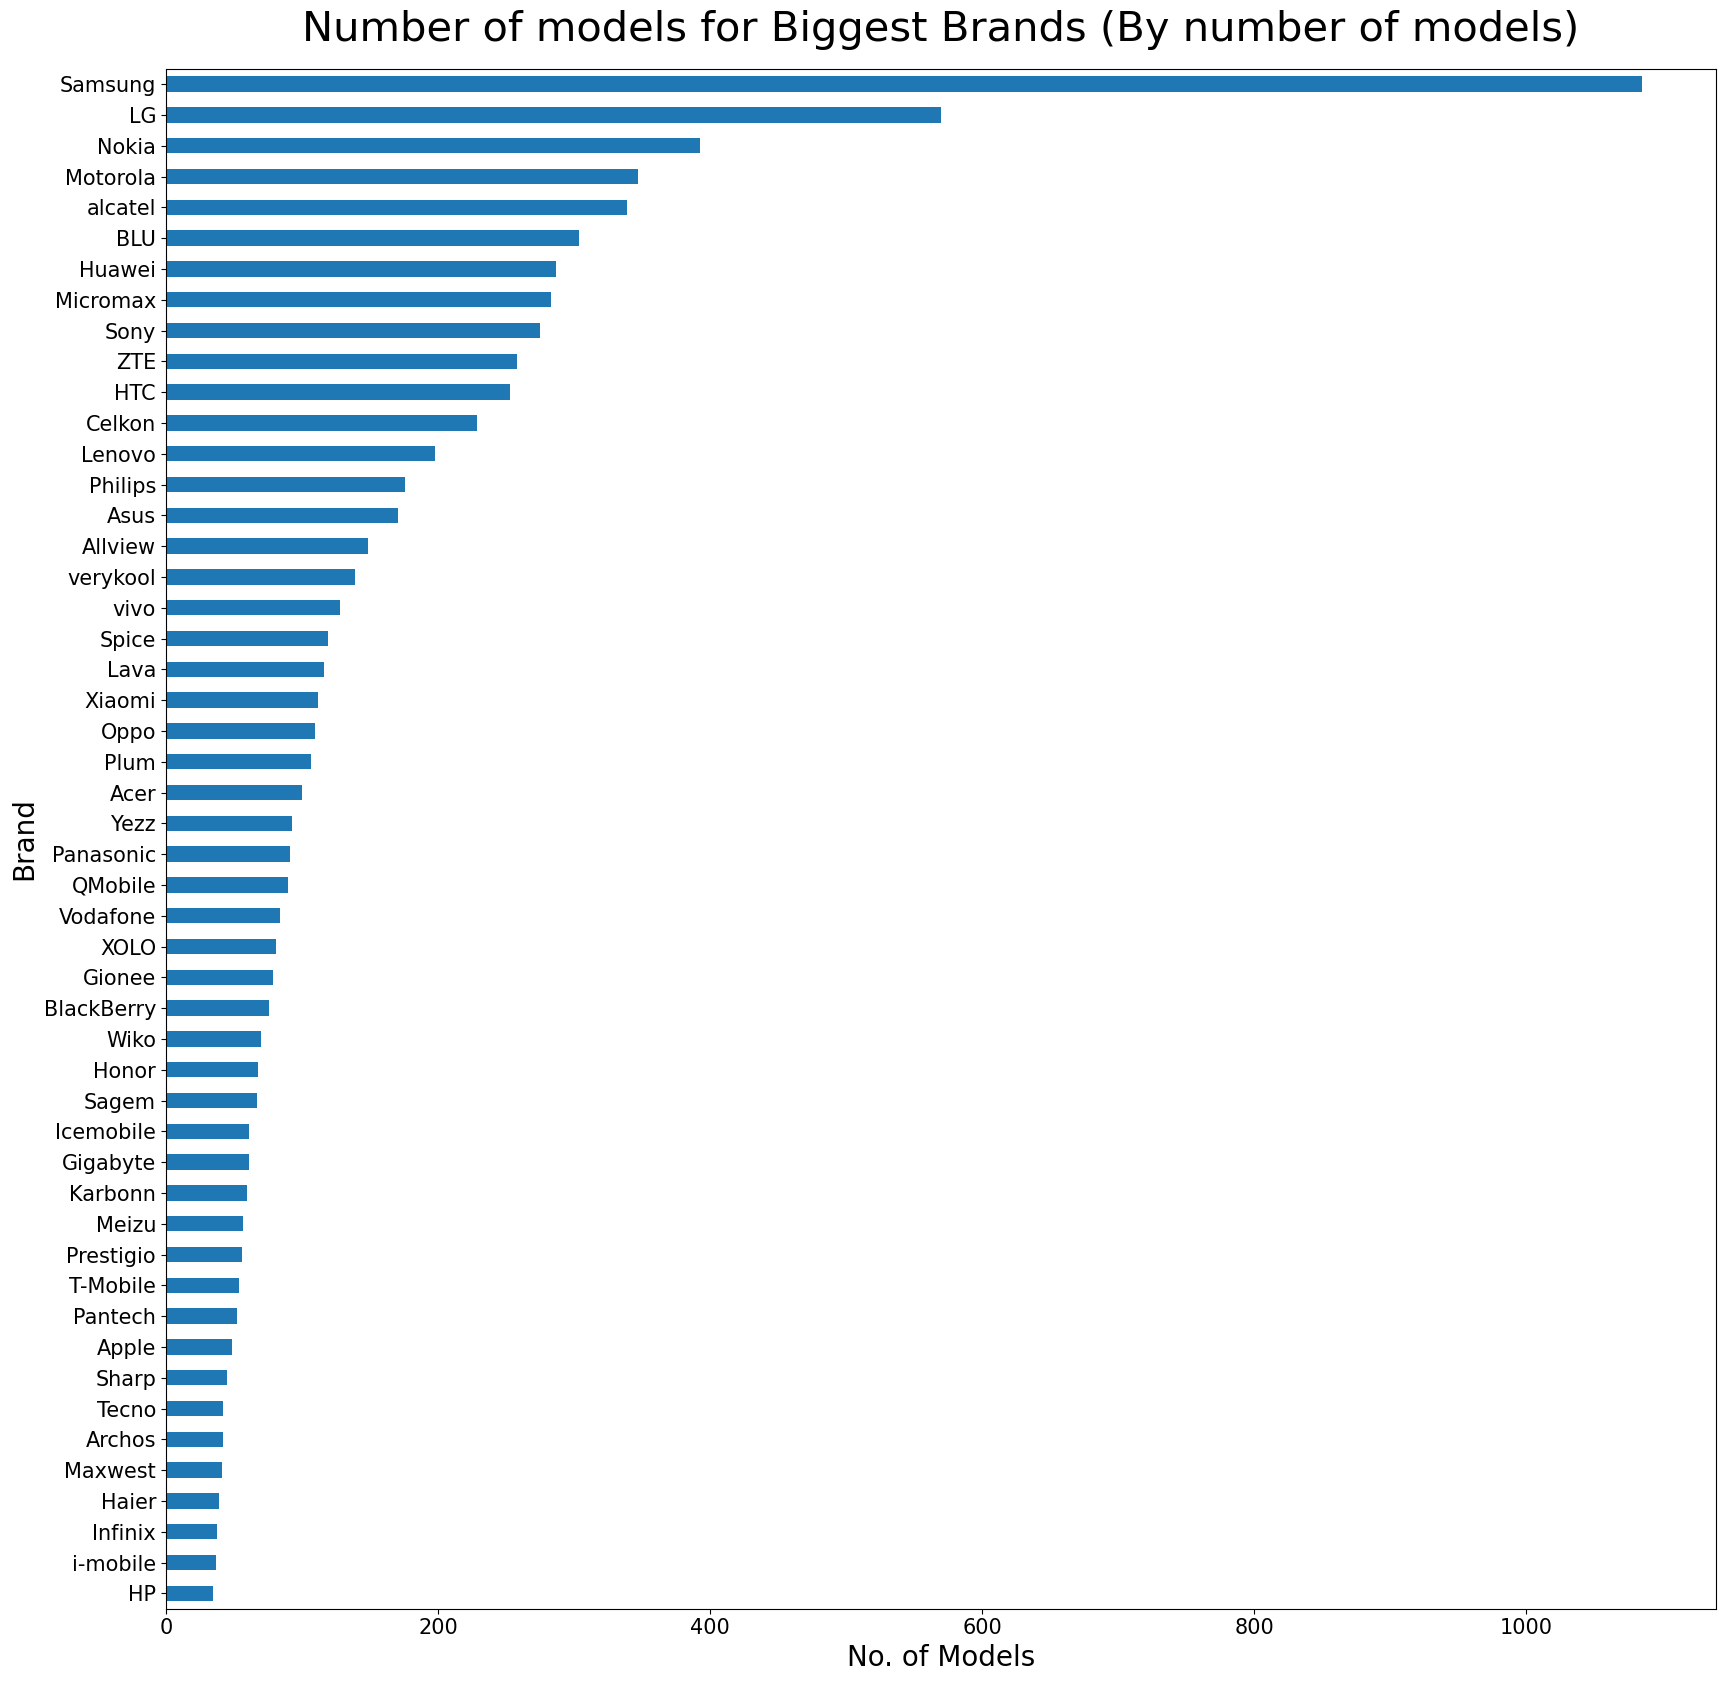

In [71]:
plot = filtered_phones.groupby("Brand").count()["id"].sort_values().tail(50).plot(kind="barh", 
                                                                           figsize=(20,20),
                                                                            fontsize=15)
plot.set_title("Number of models for Biggest Brands (By number of models)", size=30, pad=20)
plot.set_ylabel("Brand", size=20)
plot.set_xlabel("No. of Models",size=20)

### Retreive keywords (model names) associated to each Brand

In [42]:
brand_models = dict()

for brand in BRANDS_TO_ANALYZE:
    brand_models[brand] = get_brand_models(brand, filtered_phones)

## Filter Videos by Brands

In [21]:
%%time
processed_data_reader["brand"] =  processed_data_reader.apply(lambda x : find_brand(x, brand_models), axis=1)

CPU times: user 13h 30min 4s, sys: 2min 54s, total: 13h 32min 59s
Wall time: 1d 2h 54min 44s


In [22]:
processed_data_reader.to_csv(os.path.join(BASE_PATH, MODIFIED_DATA_FOLDER, VIDEOS_BRANDS_DATA))

### Clean Videos by Brand Data

In [43]:
branded_videos = pd.read_csv(os.path.join(BASE_PATH, MODIFIED_DATA_FOLDER, VIDEOS_BRANDS_DATA), index_col=0)

In [44]:
branded_videos.head()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,brand
3968,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:31.549534,Climate change threatens to make dry regions e...,503.0,XPSYzLZ7xKU,200,15328.0,"seeker,science,curiosity,education,explain,lea...",Transforming Air Into Pure Drinking Water Is F...,2019-10-03 00:00:00,357909.0,NaN
3969,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:32.224556,We now have a new understanding of the undergr...,84.0,WWD_1Nq6iwQ,308,6498.0,"seeker,science,curiosity,education,explain,lea...",This Underground Economy Exists in a Secret Fu...,2019-10-02 00:00:00,151492.0,NaN
3970,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:32.905550,Glaucoma is one of the leading causes of blind...,36.0,0U1rkFraBQo,399,2723.0,"SICK,science,health,health news,health tech,te...",How Does Glaucoma Cause Vision Loss?,2019-10-01 00:00:00,63057.0,NaN
3971,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:33.614600,NASA and Arizona State University plan to send...,111.0,NMknT8vKOL8,292,5274.0,"NASA,Arizona State University,asteroid,asteroi...",This Metal Asteroid Could Reveal Secrets About...,2019-09-30 00:00:00,229530.0,NaN
3972,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:34.300370,An international team of scientists and engine...,156.0,s0P9hj1R_Zw,486,10025.0,"focal point,documentary,interview,short doc,sc...","The International Hunt for Dark Energy Is On, ...",2019-09-29 00:00:00,322653.0,NaN


In [175]:
# Only interested in the videos that talk about atleast one phone
branded_videos = branded_videos[~branded_videos.brand.isna()]

upload_date_datetime = pd.to_datetime(branded_videos.upload_date)
branded_videos = branded_videos.set_index(upload_date_datetime).drop("upload_date", axis=1)

In [176]:
videos_by_brand = dict()
for brand in BRANDS_TO_ANALYZE:
    contains_this_brand = branded_videos.brand.apply(lambda x : brand in x) 
    videos_by_brand[brand] = branded_videos[contains_this_brand]

## Simple Analysis

In [177]:
STATS = ['total_views','number_videos','average_views_video',
         'average_duration_video','nbr_channels_covering_brand',
         'nbr_vid_per_chnl_covering_brand','nbr_likes',
         'nbr_dislikes','like_dislike_ratio',
         'average_dislike_video','average_like_video',
         'percentage_like_per_viewer','percentage_dislike_per_viewer',
         'number_products','nbr_views_per_product', 'nbr_videos_per_product']


# Computed by code
nbr_prodcts_brand = {'Samsung':1085,'Apple':49,'Xiaomi':112,'LG':570,'Huawei':287,'Oppo':110}

stats_brand_df =  pd.DataFrame(columns=STATS,index=BRANDS_TO_ANALYZE)

for brand in BRANDS_TO_ANALYZE:
    
    brand_df = videos_by_brand[brand]

    stats_brand_df.loc[brand].number_products = nbr_prodcts_brand[brand]
    stats_brand_df.loc[brand].total_views = int(brand_df.view_count.astype(float).sum())
    stats_brand_df.loc[brand].nbr_views_per_product = int(stats_brand_df.loc[brand].total_views/stats_brand_df.loc[brand].number_products)
    stats_brand_df.loc[brand].nbr_videos_per_product = int(len(brand_df)/stats_brand_df.loc[brand].number_products)
    stats_brand_df.loc[brand].number_videos = len(brand_df)
    stats_brand_df.loc[brand].average_views_video = int((brand_df.view_count.astype(float).sum())/len(brand_df))
    stats_brand_df.loc[brand].average_duration_video = int(brand_df.duration.astype(float).mean())
    stats_brand_df.loc[brand].nbr_channels_covering_brand = int(brand_df.channel_id.nunique())
    stats_brand_df.loc[brand].nbr_likes = int(brand_df.like_count.astype(float).sum())
    stats_brand_df.loc[brand].nbr_dislikes = int(brand_df.dislike_count.astype(float).sum())
    stats_brand_df.loc[brand].like_dislike_ratio = stats_brand_df.loc[brand].nbr_likes/stats_brand_df.loc[brand].nbr_dislikes
    stats_brand_df.loc[brand].average_like_video = int((brand_df.like_count.astype(float).sum())/len(brand_df))
    stats_brand_df.loc[brand].percentage_like_per_viewer = (stats_brand_df.loc[brand].nbr_likes/stats_brand_df.loc[brand].total_views)*100
    stats_brand_df.loc[brand].average_dislike_video = int((brand_df.dislike_count.astype(float).sum())/len(brand_df))
    stats_brand_df.loc[brand].percentage_dislike_per_viewer = (stats_brand_df.loc[brand].nbr_dislikes/stats_brand_df.loc[brand].total_views)*100
    stats_brand_df.loc[brand].nbr_vid_per_chnl_covering_brand = stats_brand_df.loc[brand].number_videos/stats_brand_df.loc[brand].nbr_channels_covering_brand

In [178]:
stats_brand_df

,total_views,number_videos,average_views_video,average_duration_video,nbr_channels_covering_brand,nbr_vid_per_chnl_covering_brand,nbr_likes,nbr_dislikes,like_dislike_ratio,average_dislike_video,average_like_video,percentage_like_per_viewer,percentage_dislike_per_viewer,number_products,nbr_views_per_product,nbr_videos_per_product
Samsung,8715133292,77793,112029,416,2055,37.855474,111262538,10449405,10.647739,134,1430,1.276659,0.1199,1085,8032380,71
Apple,4855947218,21067,230500,412,1500,14.044667,75806373,6072687,12.483168,288,3598,1.561104,0.125057,49,99100963,429
LG,1797544361,28665,62708,440,1155,24.818182,27032841,1758060,15.376518,61,943,1.503876,0.097803,570,3153586,50
Huawei,2174618135,21711,100162,420,949,22.877766,37621168,2459668,15.295222,113,1732,1.730013,0.113108,287,7577066,75
Xiaomi,2042090246,28984,70455,399,1081,26.812211,38080121,3164994,12.031657,109,1313,1.864762,0.154988,112,18232948,258
Oppo,2656767222,13143,202143,404,719,18.279555,31079483,2801537,11.093726,213,2364,1.169823,0.105449,110,24152429,119


### Visualization

<AxesSubplot: title={'center': 'Avg. length of videos for each brand'}, xlabel='Duration (Minutes)', ylabel='Brands'>

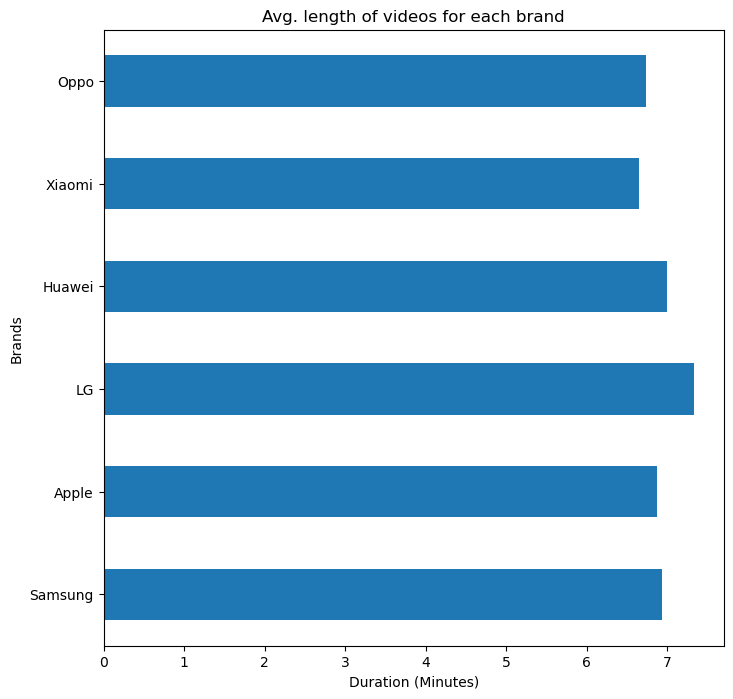

In [179]:
stats_brand_df.average_duration_video.apply(lambda x: x/60).plot(kind="barh", 
                                                                 title="Avg. length of videos for each brand", 
                                                                 figsize=(8, 8), xlabel="Duration (Minutes)", 
                                                                 ylabel="Brands") 

Text(0, 0.5, '')

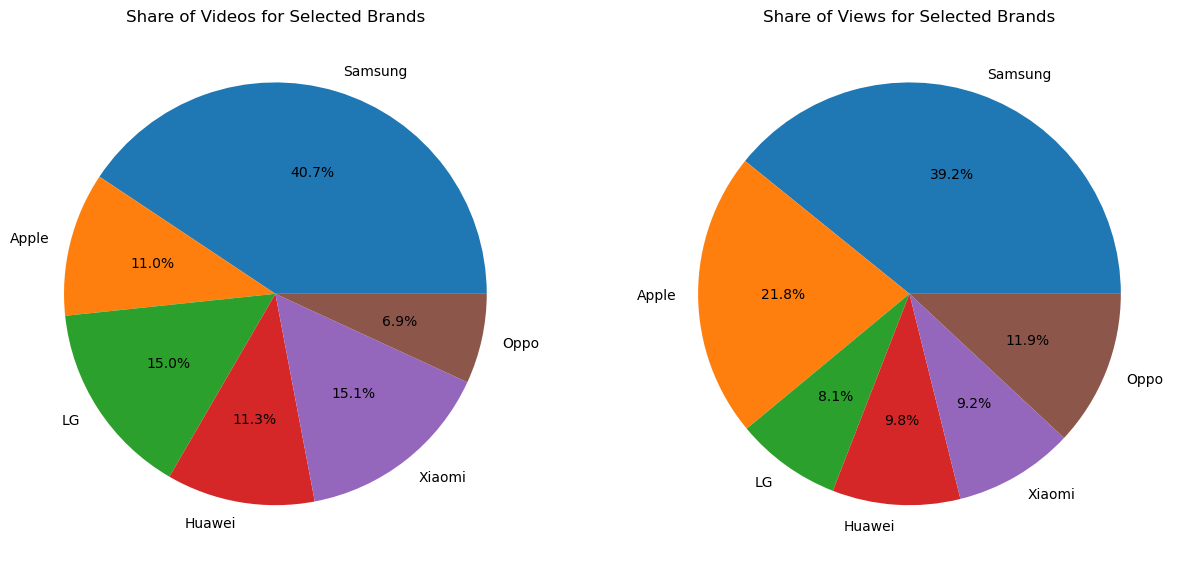

In [180]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))

#          'average_views_video','nbr_channels_covering_brand'

stats_brand_df.number_videos.plot.pie(ax=ax1,legend=False, autopct='%1.1f%%')
stats_brand_df.total_views.plot.pie(ax=ax2,legend=False, autopct='%1.1f%%')
ax1.set_title("Share of Videos for Selected Brands")
ax2.set_title("Share of Views for Selected Brands")
ax1.set_ylabel(None)
ax2.set_ylabel(None)

Text(0, 0.5, 'No. of Channels')

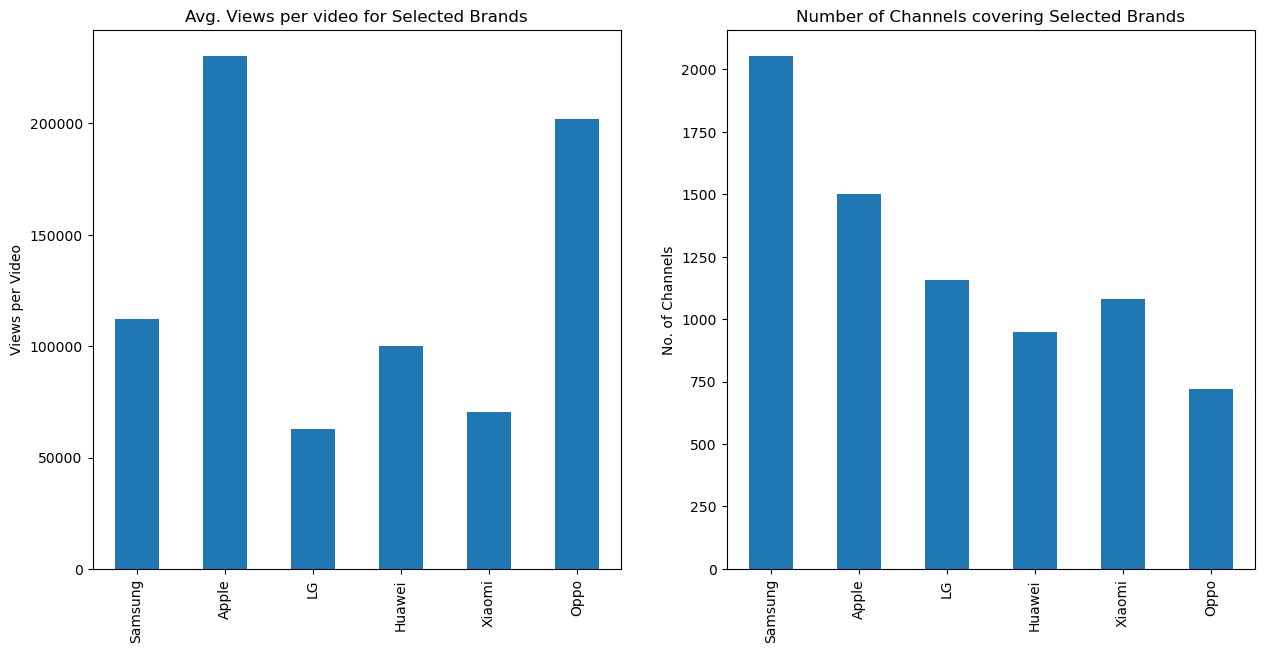

In [181]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

stats_brand_df.average_views_video.plot.bar(ax=ax1)
stats_brand_df.nbr_channels_covering_brand.plot.bar(ax=ax2)
ax1.set_title("Avg. Views per video for Selected Brands")
ax2.set_title("Number of Channels covering Selected Brands")
ax1.set_ylabel("Views per Video")
ax2.set_ylabel("No. of Channels")

Text(0, 0.5, 'No. of Dislikes')

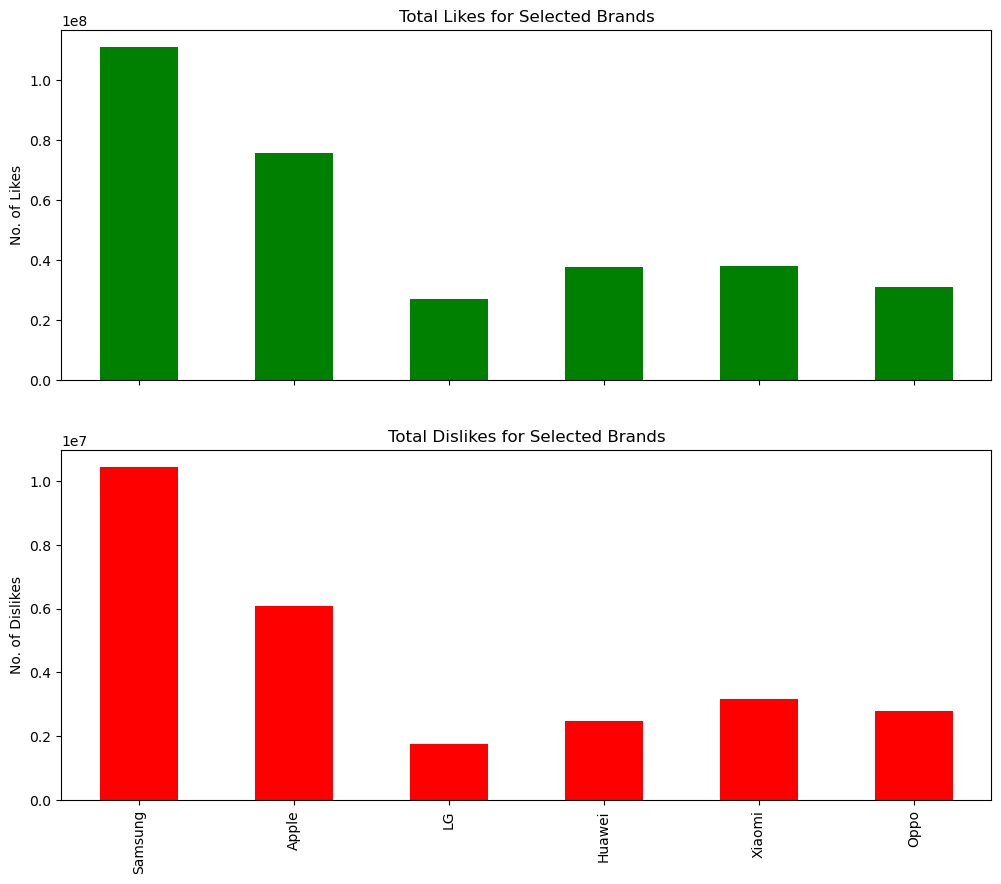

In [182]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

stats_brand_df.nbr_likes.plot.bar(ax=ax1, color="green")
stats_brand_df.nbr_dislikes.plot.bar(ax=ax2, color="red")
ax1.set_title("Total Likes for Selected Brands")
ax2.set_title("Total Dislikes for Selected Brands")
ax1.set_ylabel("No. of Likes")
ax2.set_ylabel("No. of Dislikes")

Text(0, 0.5, 'Avg Dislikes per Video')

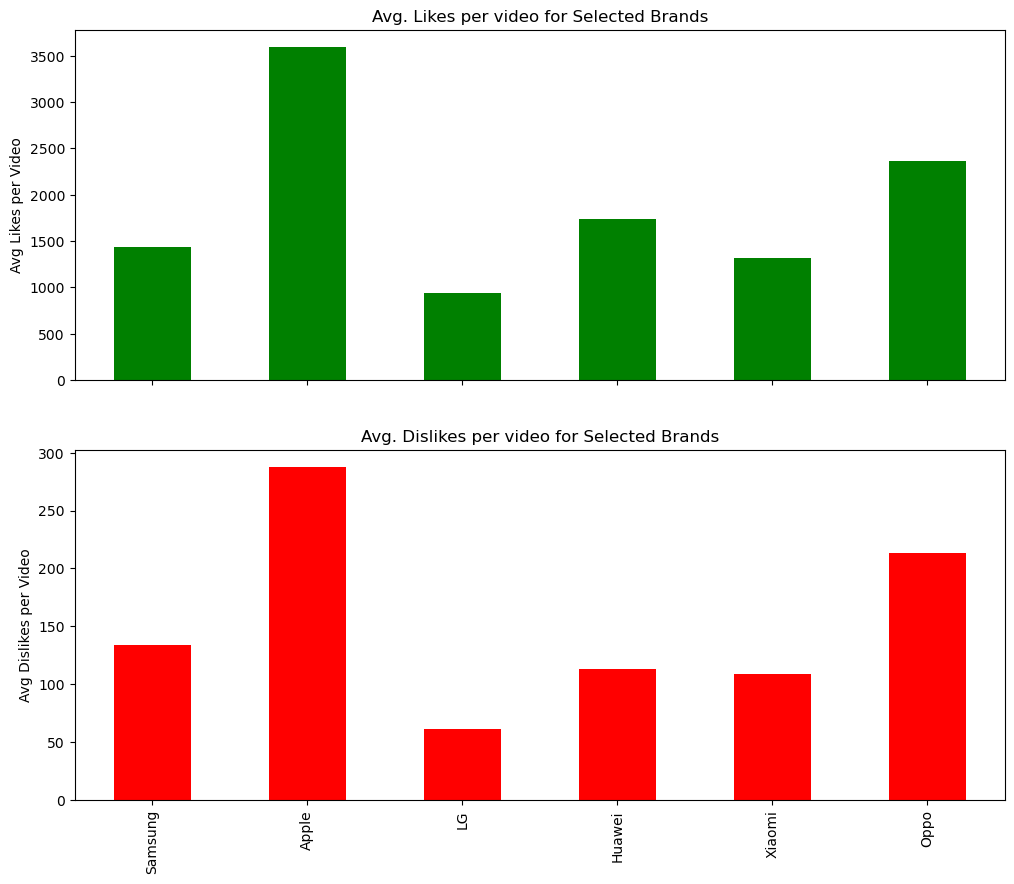

In [183]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

stats_brand_df.average_like_video.plot.bar(ax=ax1, color="green")
stats_brand_df.average_dislike_video.plot.bar(ax=ax2, color="red")
ax1.set_title("Avg. Likes per video for Selected Brands")
ax2.set_title("Avg. Dislikes per video for Selected Brands")
ax1.set_ylabel("Avg Likes per Video")
ax2.set_ylabel("Avg Dislikes per Video")

### Needs an explanation

Text(0, 0.5, '% Dislikes per viewer')

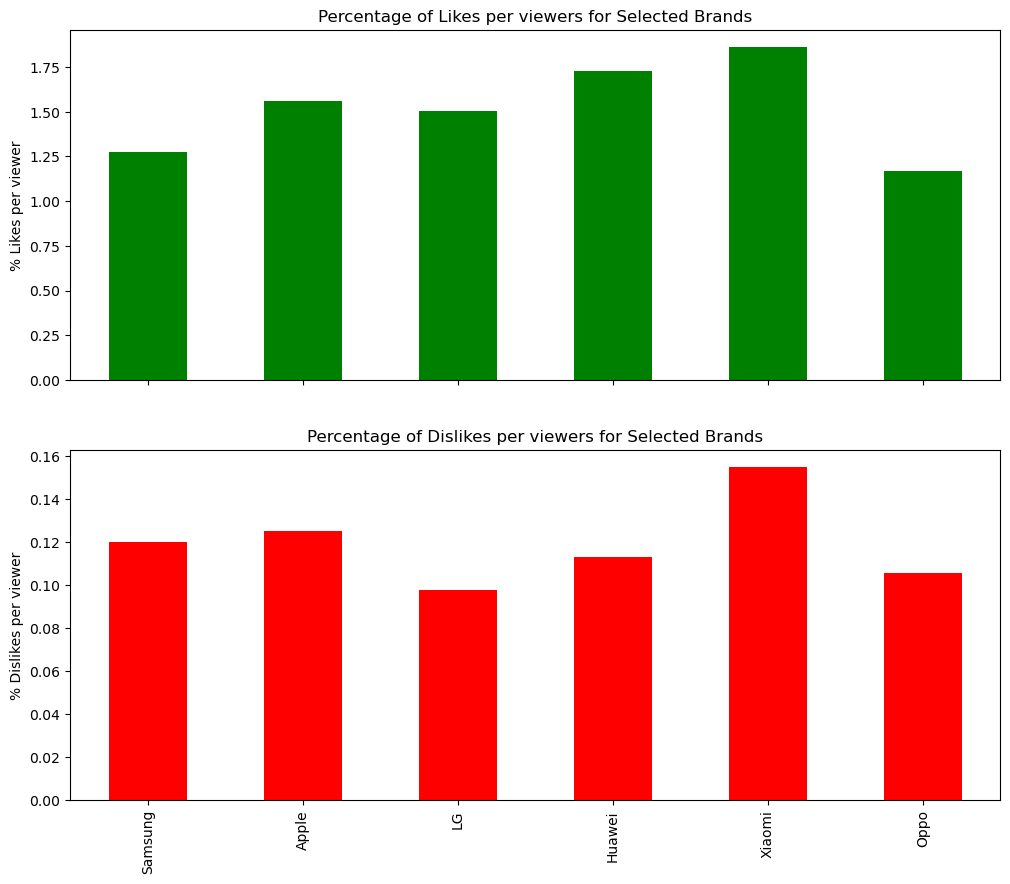

In [184]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

stats_brand_df.percentage_like_per_viewer.plot.bar(ax=ax1, color="green")
stats_brand_df.percentage_dislike_per_viewer.plot.bar(ax=ax2, color="red")
ax1.set_title("Percentage of Likes per viewers for Selected Brands")
ax2.set_title("Percentage of Dislikes per viewers for Selected Brands")
ax1.set_ylabel("% Likes per viewer")
ax2.set_ylabel("% Dislikes per viewer")


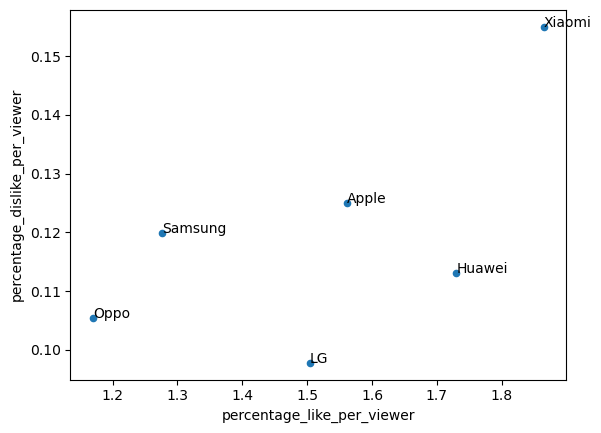

In [185]:
# plt = sns.jointplot(data=stats_brand_df, x='percentage_like_per_viewer',
#                                   y='percentage_dislike_per_viewer', kind="reg")

plot = stats_brand_df.plot.scatter(x='percentage_like_per_viewer',
                                  y='percentage_dislike_per_viewer')
for i in range(len(stats_brand_df)):
    plot.annotate(str(stats_brand_df.index[i]),(stats_brand_df.percentage_like_per_viewer[i], 
                                               stats_brand_df.percentage_dislike_per_viewer[i]))

Text(0, 0.5, 'Views per device')

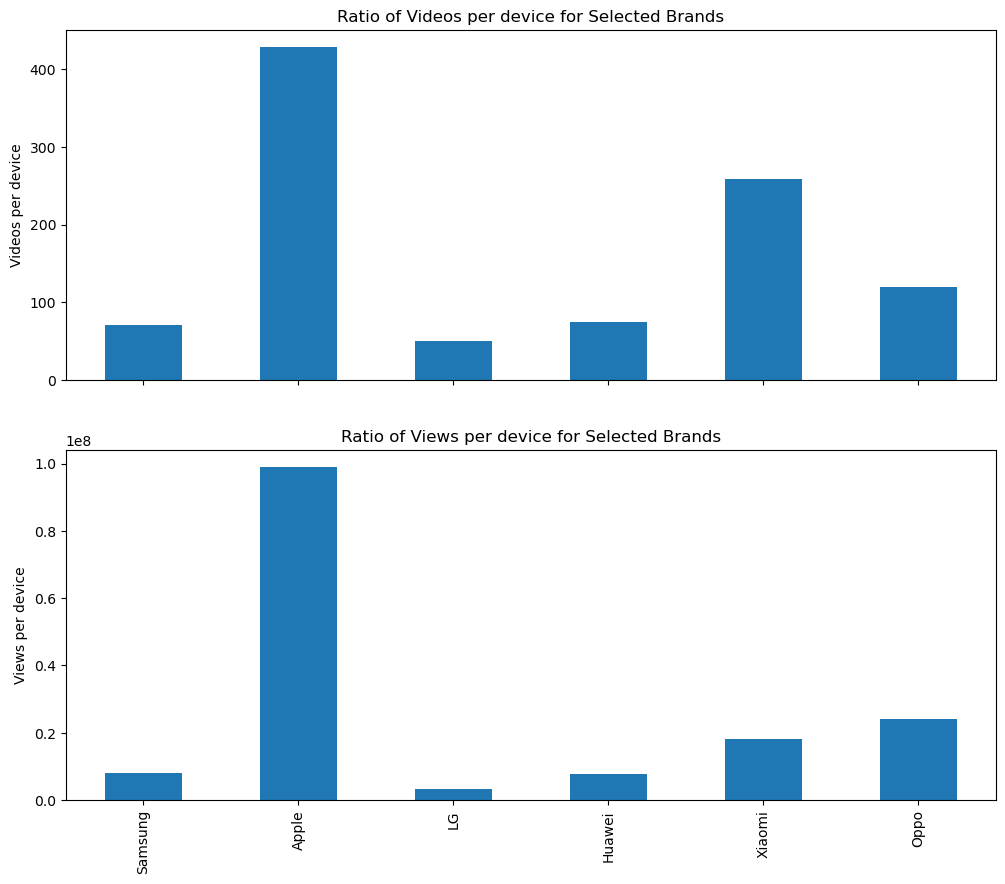

In [186]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

stats_brand_df.nbr_videos_per_product.plot.bar(ax=ax1)
stats_brand_df.nbr_views_per_product.plot.bar(ax=ax2)
ax1.set_title("Ratio of Videos per device for Selected Brands")
ax2.set_title("Ratio of Views per device for Selected Brands")
ax1.set_ylabel("Videos per device")
ax2.set_ylabel("Views per device")


## Timeseries Visualizations

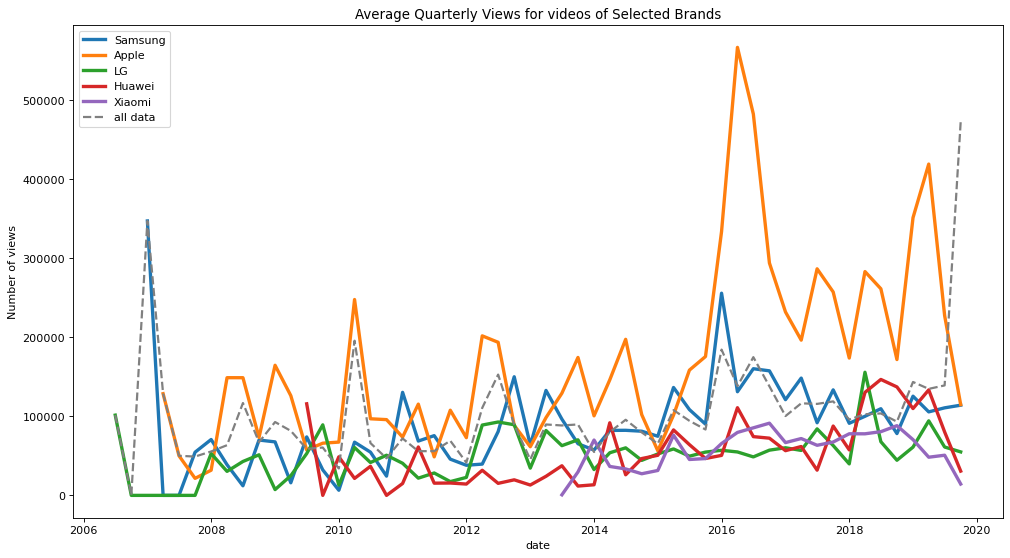

In [249]:
get_plot(BRANDS_TO_ANALYZE, "view_count", "mean", 
         videos_by_brand, figsize=(15, 8), y_label="Number of views", x_label="date", 
         title="Average Quarterly Views for videos of Selected Brands", 
         interval="QS", whole_data=branded_videos) 

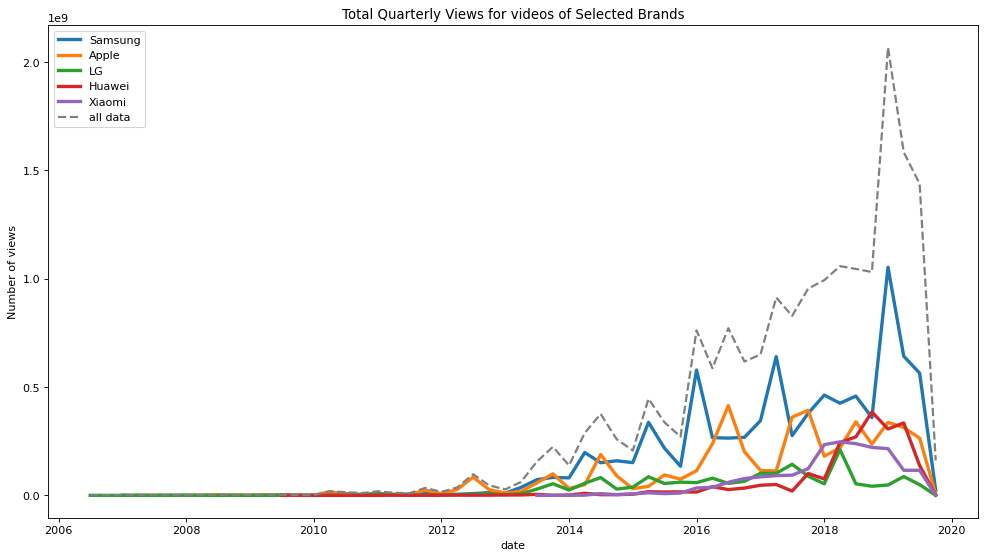

In [251]:
get_plot(BRANDS_TO_ANALYZE, "view_count", "sum", 
         videos_by_brand, figsize=(15, 8), y_label="Number of views", x_label="date", 
         title="Total Quarterly Views for videos of Selected Brands", 
         interval="QS", whole_data=branded_videos) 

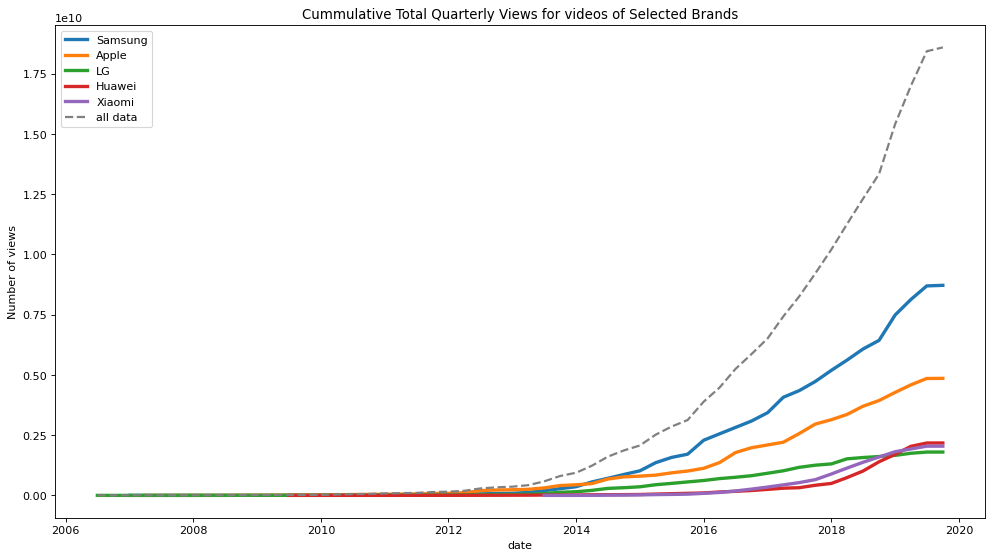

In [253]:
get_plot_cummulative(BRANDS_TO_ANALYZE, "view_count", "sum", 
         videos_by_brand, figsize=(15, 8), y_label="Number of views", x_label="date", 
         title="Cummulative Total Quarterly Views for videos of Selected Brands", 
         interval="QS", whole_data=branded_videos) 

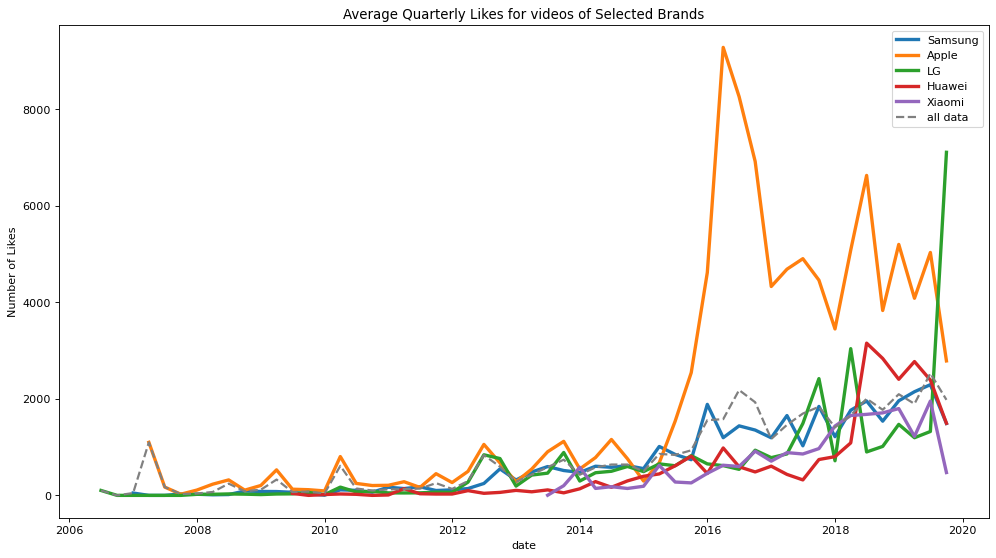

In [255]:
get_plot(BRANDS_TO_ANALYZE, "like_count", "mean", 
         videos_by_brand, figsize=(15, 8), y_label="Number of Likes", x_label="date", 
         title="Average Quarterly Likes for videos of Selected Brands", 
         interval="QS", whole_data=branded_videos)

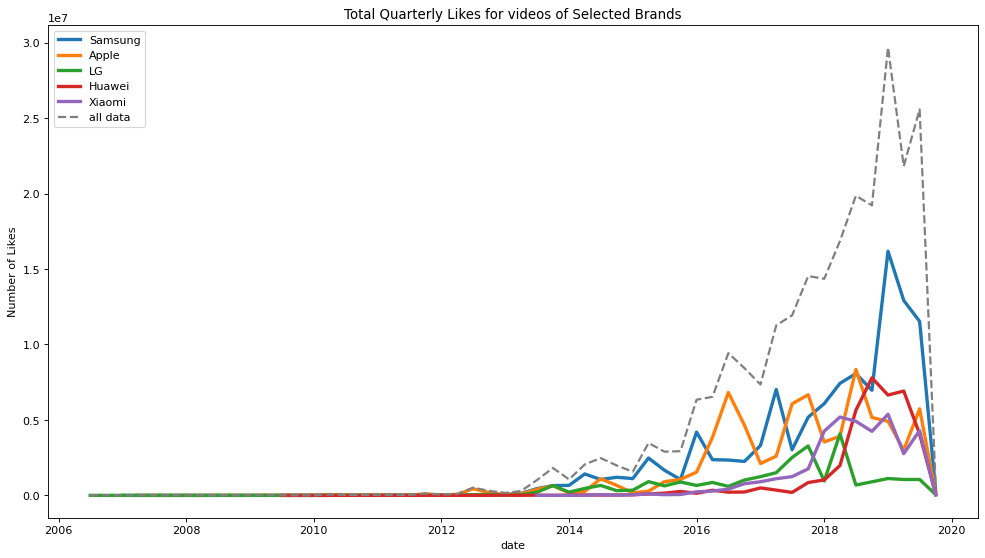

In [256]:
get_plot(BRANDS_TO_ANALYZE, "like_count", "sum", 
         videos_by_brand, figsize=(15, 8), y_label="Number of Likes", x_label="date", 
         title="Total Quarterly Likes for videos of Selected Brands", 
         interval="QS", whole_data=branded_videos)

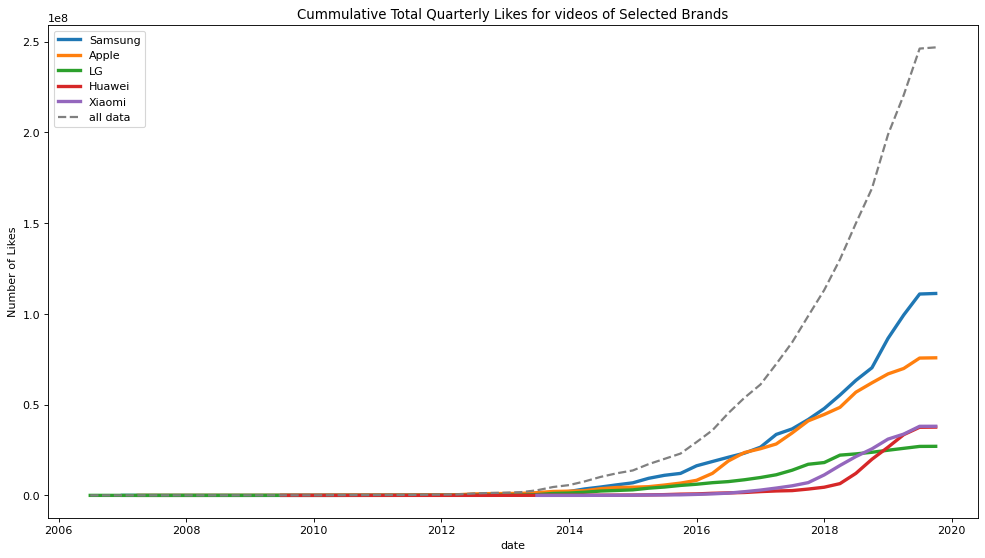

In [257]:
get_plot_cummulative(BRANDS_TO_ANALYZE, "like_count", "sum", 
         videos_by_brand, figsize=(15, 8), y_label="Number of Likes", x_label="date", 
         title="Cummulative Total Quarterly Likes for videos of Selected Brands", 
         interval="QS", whole_data=branded_videos)

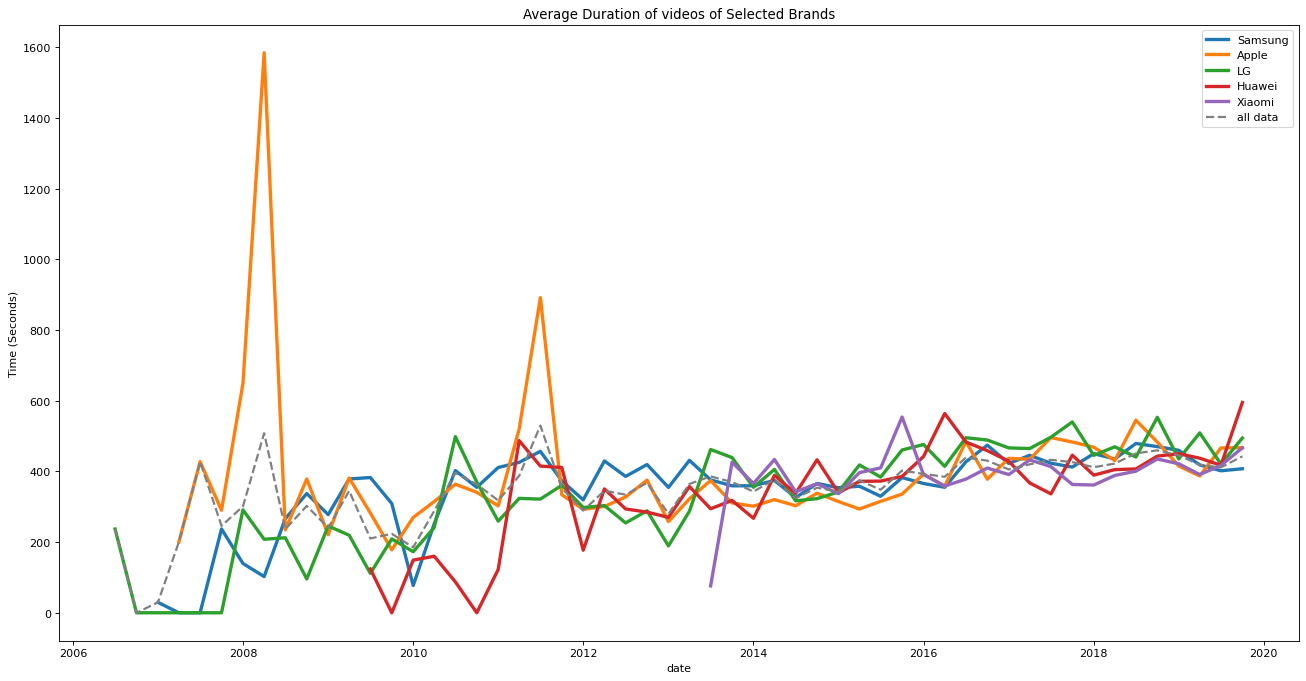

In [260]:
get_plot(BRANDS_TO_ANALYZE, "duration", "mean", 
         videos_by_brand, figsize=(20, 10), y_label="Time (Seconds)", x_label="date", 
         title="Average Duration of videos of Selected Brands", 
         interval="QS", whole_data=branded_videos)

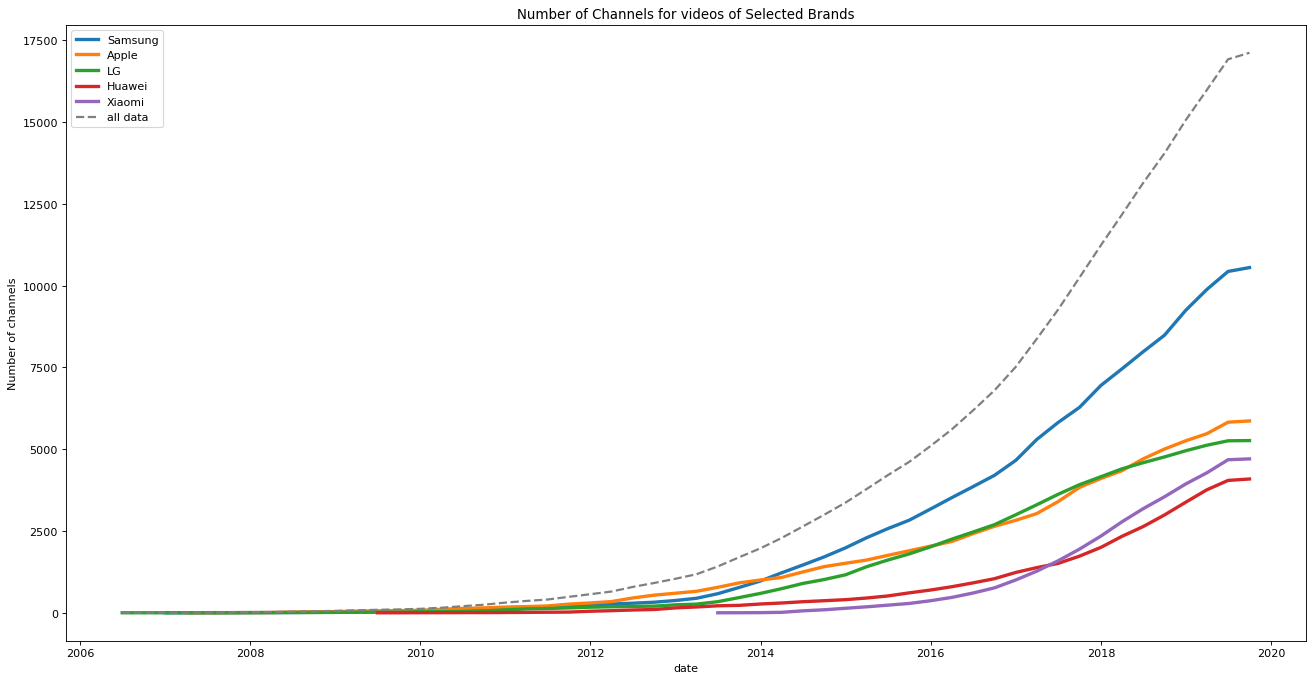

In [262]:
get_plot_cummulative(BRANDS_TO_ANALYZE, "channel_id", "nunique", 
         videos_by_brand, y_label="Number of channels", x_label="date", 
         title="Number of Channels for videos of Selected Brands", 
         interval="QS",  whole_data=branded_videos)

### Create Word Clouds

In [266]:
sample = videos_by_brand["Apple"].title

In [267]:
words = ""

for index, title in sample.items():
#     print(title)
    words += title + " "

In [268]:
img = Image.open(os.path.join(BASE_PATH, IMAGES_FOLDER, "Apple Logo.png"))
img.size

(1024, 1024)

In [269]:
img_invert = ImageOps.grayscale(img)

In [270]:
apple_mask = np.array(img_invert)
apple_mask.shape

(1024, 1024)

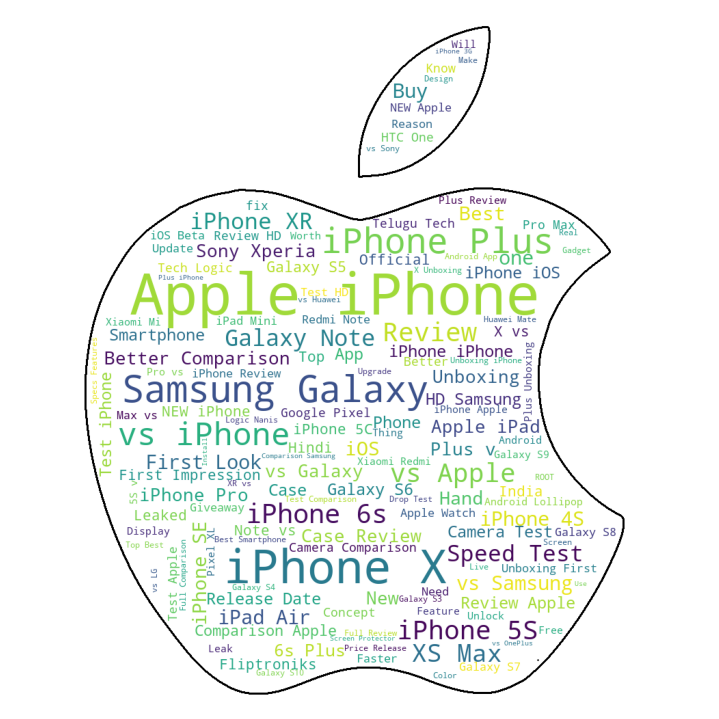

In [273]:
wordcloud = WordCloud(
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10,
                mask=apple_mask,
#                 max_words=500,
                contour_width=3, contour_color='black')

wordcloud.generate(words)
 
# plot the WordCloud image                      
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()